# GPT adder

This repo was inspired by karpathy's suggested exercice in his video [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?feature=shared)

In [ ]:
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from gpt.model import GPT, GPTConfig, TrainingConfig, Trainer

## generate samples

The following function will generate random samples for training the GPT adder.

It generates the digits of the answer in reverse order, as the typical addition algorithm would proceed right to left too.

i.e. `79+11=09` because `79+11=90`

If `DataConfig.chain_of_thought` is `True`, the answer will be broken down into atomic additions, with the carry in brackets.

i.e. `55+96;5+6=11(1);5+9+1=15;151` because to compute 55+96 you do, in this order:

- 5 + 6 = 11 carry 1
- 5 + 9 + _carry_ = 5 + 9 + 1 = 15
- result is 151

In [2]:
from dataclasses import dataclass

@dataclass
class DataConfig:
    train_low: int = 0
    train_high: int = 1000
    test_low: int = 0
    test_high: int = 1000
    chain_of_thought: bool = True

data_config = DataConfig()

In [4]:
def generate_sample(low, high, detailed=data_config.chain_of_thought):
    a = random.randint(low, high)
    b = random.randint(low, high)

    if not detailed:
        sample = f"{a}+{b}="
        prompt_end_idx = len(sample) - 1
        res = a + b

        # add in reverse order
        sample += str(res)[::-1]

        return sample, prompt_end_idx
    
    sample = f"{a}+{b};"

    # give the index of the last character of the prompt (useful for ignore_index of cross entropy loss, see later...)
    prompt_end_idx = len(sample) - 1

    array_of_numbers_a = [int(x) for x in str(a)]
    array_of_numbers_b = [int(x) for x in str(b)]

    carry = 0

    while len(array_of_numbers_a) and len(array_of_numbers_b):
        prefix_carry = f"+{carry}" if carry else ""

        d1 = array_of_numbers_a.pop()
        d2 = array_of_numbers_b.pop()

        res = d1 + d2 + carry

        carry = res//10

        if len(array_of_numbers_a) == 0 and len(array_of_numbers_b) == 0:
            sample += f"{d1}+{d2}{prefix_carry}={res};"
        else:
            sample += f"{d1}+{d2}{prefix_carry}={res}({carry});"

    while len(array_of_numbers_a):
        d1 = array_of_numbers_a.pop()
        d2 = carry
        res = d1 + d2
        carry = res//10
        if len(array_of_numbers_a) > 0:
            sample += f"{d1}+{d2}={res}({carry});"
        else:
            sample += f"{d1}+{d2}={res};"

    while len(array_of_numbers_b):
        d1 = array_of_numbers_b.pop()
        d2 = carry
        res = d1 + d2
        carry = res//10
        if len(array_of_numbers_b) > 0:
            sample += f"{d1}+{d2}={res}({carry});"
        else:
            sample += f"{d1}+{d2}={res};"

    sample += f"{a+b}"

    return sample, prompt_end_idx

# get a sample from the training set
sample, prompt_idx = generate_sample(low=data_config.train_low, high=data_config.train_high)
sample, prompt_idx

('424+699;4+9=13(1);2+9+1=12(1);4+6+1=11;1123', 7)

In [5]:
# get a sample from the test set
sample, prompt_idx = generate_sample(low=data_config.test_low, high=data_config.test_high)
sample, prompt_idx

('101+456;1+6=7(0);0+5=5(0);1+4=5;557', 7)

In [6]:
def extract_prompt_from_sample(sample, prompt_idx):
    """extract only the prompt from a full addition sample"""
    return sample[:prompt_idx+1]

extract_prompt_from_sample(sample, prompt_idx)

'101+456;'

In [7]:
def correct_answer(sample, model_output, only_result=False):
    """check if the model calculated the correct answer by comparing against the ground truth"""
    if only_result:
        response = f";{sample.split(';')[-1]}<|endoftext|>"
        return response in model_output
    else:
        return model_output == (sample + "<|endoftext|>")

correct_answer(sample, sample + "<|endoftext|>", only_result=True)

True

## build the vocab

In [8]:
tokens = set()
for i in range(10):
    tokens.add((str(i)))

if data_config.chain_of_thought:
    tokens.add("+")
    tokens.add("=")
    tokens.add(";")
    tokens.add("(")
    tokens.add(")")
else:
    tokens.add("+")
    tokens.add("=")
tokens.add("<|endoftext|>")
tokens

{'(',
 ')',
 '+',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ';',
 '<|endoftext|>',
 '='}

## create config

In [12]:
model_config = GPTConfig(
    vocab_size=len(tokens),
    block_size=64,
    n_embd=128,
    n_head=4,
    n_layer=1,
    dropout=0.2
)

train_config = TrainingConfig(
    batch_size=32,
    max_iters=5000,
    eval_iters=100,
    eval_interval=1000,
    learning_rate=1e-3,
    weight_decay=1e-1
)

model_config, train_config

(GPTConfig(vocab_size=16, block_size=64, n_embd=128, n_head=4, n_layer=1, dropout=0.2, device='cpu', eos_token_id=-1),
 TrainingConfig(batch_size=32, max_iters=5000, eval_iters=100, eval_interval=1000, learning_rate=0.001, weight_decay=0.1))

## tokenizer

In [13]:
stoi = { s:i for i,s in enumerate(tokens) }
itos = { i:s for i,s in enumerate(tokens) }

def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

In [14]:
EOS_ID = stoi['<|endoftext|>']
model_config.eos_token_id = EOS_ID
EOS_ID

4

## model definition

In [15]:
model = GPT(config=model_config)

# put the model on the device
model.to(model_config.device)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters()), 'parameters')

210448 parameters


## data loader and trainer

The tokens that belongs to the prompt are converted into `-1` in the label vector, as the loss will not be calculated for these tokens (see `ignore_index` of the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)).

In [16]:
class AdderTrainer(Trainer):
    def __init__(self, model, model_config, train_config):
        super().__init__(model=model, model_config=model_config, train_config=train_config)

    def get_batch(self, split: str = "train"):
        X, Y = [], []
        for k in range(self.train_config.batch_size):
            sample, prompt_end_idx = generate_sample(low=data_config.train_low, high=data_config.train_high)
            encoded_sample = torch.tensor(encode(sample))

            # add EOS token
            encoded_sample = torch.cat((encoded_sample, torch.tensor([EOS_ID])))

            x = encoded_sample[:-1].clone()
            y = encoded_sample[1:].clone()

            y[:prompt_end_idx] = -1
            X.append(x)
            Y.append(y)

        X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=EOS_ID)
        Y = torch.nn.utils.rnn.pad_sequence(Y, batch_first=True, padding_value=-1)
            
        X, Y = X.to(self.model_config.device), Y.to(self.model_config.device)
        return X, Y

    @torch.no_grad()
    def estimate_loss(self):
        out = {}
        self.model.eval()
        losses = torch.zeros(self.train_config.eval_iters)
        for k in tqdm(range(self.train_config.eval_iters)):
            X, Y = self.get_batch()
            logits, loss = self.model(X, Y)
            losses[k] = loss.item()
        out["val"] = losses.mean()
        out["train"] = losses.mean()
        self.model.train()
        return out

trainer = AdderTrainer(model, model_config, train_config)

x, y = trainer.get_batch()
x.shape, y.shape

(torch.Size([32, 43]), torch.Size([32, 43]))

In [17]:
idx = 2
print(f"y={y[idx]}")
print(f"x={x[idx]}")

without_ignore_index = y[idx].tolist()
without_ignore_index = [i for i in without_ignore_index if i != -1]

print(f"y={decode(without_ignore_index)}")
print(f"x={decode(x[idx].tolist())}")

y=tensor([-1, -1, -1, -1, -1, -1, -1,  0,  9,  8, 13,  1, 14, 10,  1, 11,  3,  2,
         9,  2,  9,  1, 13,  1, 10,  2, 11,  3,  1,  9,  5, 13,  6,  3,  6,  1,
        14,  4, -1, -1, -1, -1, -1])
x=tensor([ 1,  2,  0,  9,  5,  2,  8,  3,  0,  9,  8, 13,  1, 14, 10,  1, 11,  3,
         2,  9,  2,  9,  1, 13,  1, 10,  2, 11,  3,  1,  9,  5, 13,  6,  3,  6,
         1, 14,  4,  4,  4,  4,  4])
y=6+8=14(1);0+0+1=1(0);1+2=3;314<|endoftext|>
x=106+208;6+8=14(1);0+0+1=1(0);1+2=3;314<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [18]:
train_losses, val_losses = trainer.train()

0.210448 M parameters


training:   0%|          | 7/5000 [00:00<06:24, 12.97it/s]

step 0: train loss 2.8007, val loss 2.8007


training:  20%|██        | 1007/5000 [00:17<02:23, 27.89it/s]

step 1000: train loss 0.0157, val loss 0.0157


training:  40%|████      | 2011/5000 [00:35<01:43, 28.94it/s]

step 2000: train loss 0.0083, val loss 0.0083


training:  60%|██████    | 3008/5000 [00:52<01:03, 31.57it/s]

step 3000: train loss 0.0072, val loss 0.0072


training:  80%|████████  | 4008/5000 [01:08<00:31, 31.87it/s]

step 4000: train loss 0.0041, val loss 0.0041


training: 100%|██████████| 5000/5000 [01:25<00:00, 58.63it/s]

step 4999: train loss 0.0064, val loss 0.0064


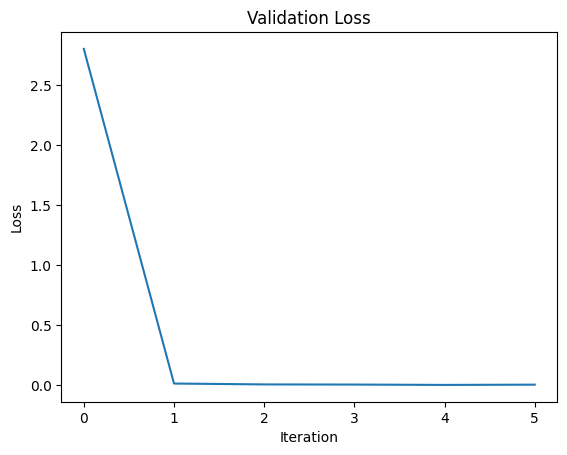

In [19]:
plt.plot(val_losses)
plt.xlabel(xlabel="Iteration")
plt.ylabel(ylabel="Loss")
plt.title("Validation Loss")
plt.show()

In [20]:
def get_model_response(prompt):
    context = torch.tensor(encode(prompt), device=model_config.device)
    context = context.unsqueeze(0)

    generated = model.generate(context, max_new_tokens=70)[0].tolist()
    decoded = decode(generated)
    return decoded

In [21]:
get_model_response("6+9;")

'6+9;9+9=133(0);9+0=9+1=17(1);6+1=7;770<|endoftext|>'

## evaluation

In [22]:
def accuracy(model: GPT, num_to_run=1000, verbose=False):
    score = 0

    goods, wrongs = [], []

    for _ in tqdm(range(num_to_run)):
        result = {}

        sample, prompt_idx = generate_sample(low=data_config.test_low, high=data_config.test_high)

        prompt = extract_prompt_from_sample(sample, prompt_idx)

        result['prompt'] = prompt

        # generate from the model
        context = torch.tensor(encode(prompt), device=model_config.device)
        context = context.unsqueeze(0)

        generated = model.generate(context, max_new_tokens=70)[0].tolist()
        decoded = decode(generated)

        if verbose:
            print(f"prompt: {prompt}")
            print(f"decoded: {decoded}")
            print(f"sample: {sample}")
            print(f"correct: {correct_answer(sample, decoded)}")
            print()

        result['decoded'] = decoded

        correct = correct_answer(sample, decoded)

        result['correct'] = correct

        if correct:
            score += 1
            goods.append(result)
        else:
            wrongs.append(result)

    return score / num_to_run, goods, wrongs

In [23]:
score, goods, wrongs = accuracy(model, num_to_run=1000, verbose=False)
print(f"Accuracy: {score*100}%")

100%|██████████| 1000/1000 [00:24<00:00, 40.88it/s]

Accuracy: 80.60000000000001%


In [24]:
import json
print(len(goods))
print(json.dumps(goods[:10], indent=2))

806
[
  {
    "prompt": "946+331;",
    "decoded": "946+331;6+1=7(0);4+3=7(0);9+3=12;1277<|endoftext|>",
    "correct": true
  },
  {
    "prompt": "972+161;",
    "decoded": "972+161;2+1=3(0);7+6=13(1);9+1+1=11;1133<|endoftext|>",
    "correct": true
  },
  {
    "prompt": "574+588;",
    "decoded": "574+588;4+8=12(1);7+8+1=16(1);5+5+1=11;1162<|endoftext|>",
    "correct": true
  },
  {
    "prompt": "414+480;",
    "decoded": "414+480;4+0=4(0);1+8=9(0);4+4=8;894<|endoftext|>",
    "correct": true
  },
  {
    "prompt": "120+552;",
    "decoded": "120+552;0+2=2(0);2+5=7(0);1+5=6;672<|endoftext|>",
    "correct": true
  },
  {
    "prompt": "188+835;",
    "decoded": "188+835;8+5=13(1);8+3+1=12(1);1+8+1=10;1023<|endoftext|>",
    "correct": true
  },
  {
    "prompt": "407+421;",
    "decoded": "407+421;7+1=8(0);0+2=2(0);4+4=8;828<|endoftext|>",
    "correct": true
  },
  {
    "prompt": "713+487;",
    "decoded": "713+487;3+7=10(1);1+8+1=10(1);7+4+1=12;1200<|endoftext|>",
    "correct

In [25]:
print(len(wrongs))
print(json.dumps(wrongs[:10], indent=2))

194
[
  {
    "prompt": "66+826;",
    "decoded": "66+826;6+6=12(1);8+2+1=11(1);8+1=9;912<|endoftext|>",
    "correct": false
  },
  {
    "prompt": "476+977;",
    "decoded": "476+977;6+7=13(1);7+7+1=15(1);4+9+1=10;1053<|endoftext|>",
    "correct": false
  },
  {
    "prompt": "198+71;",
    "decoded": "198+71;8+1=9(0);9+7=10(1);1+1=2;209<|endoftext|>",
    "correct": false
  },
  {
    "prompt": "76+291;",
    "decoded": "76+291;6+1=7(0);2+9=11(1);2+1=3;317<|endoftext|>",
    "correct": false
  },
  {
    "prompt": "532+655;",
    "decoded": "532+655;2+5=10(1);3+5+1=9(0);5+6=11;1190<|endoftext|>",
    "correct": false
  },
  {
    "prompt": "565+20;",
    "decoded": "565+20;5+0=5(0);6+2=8(0);7+0=7;785<|endoftext|>",
    "correct": false
  },
  {
    "prompt": "80+46;",
    "decoded": "80+46;0+6=1(0);8+4=12;121);4+2+222;212<|endoftext|>",
    "correct": false
  },
  {
    "prompt": "487+607;",
    "decoded": "487+607;7+7=14(1);8+0+1=8(0);4+6=10;1084<|endoftext|>",
    "correct": fals